#  1. Importing Libraries

In [29]:
# Import the necessary libraries for data handling and visualisations
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import the necessary libraries for data preprocessing, transformation and feature selection
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import  mutual_info_classif
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Import the necessary libraries for model building and evaluation
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_recall_curve, average_precision_score, roc_auc_score, RocCurveDisplay
import scipy.stats as stats

In [30]:
# Declaring the necessary variables for the project
# Name of the dataset
FILE_NAME = "lending_club_dataset.csv"

# Target variable of the dataset
TARGET_VARIABLE = "loan_status"

___
# 2. Data Import

In [31]:
# Define the path to the dataset
file_path = os.path.join(os.getcwd(), FILE_NAME)

In [32]:
# Loading the dataset
df = pd.read_csv(file_path)
df.head()

,issue_d,sub_grade,term,home_ownership,fico_range_low,total_acc,pub_rec,revol_util,annual_inc,int_rate,...,pub_rec_bankruptcies,addr_state,initial_list_status,fico_range_high,revol_bal,id,open_acc,emp_length,loan_status,time_to_earliest_cr_line
0,2014-01-01,D1,60 months,MORTGAGE,660.0,18.0,0.0,86.8,40440.0,16.99,...,0.0,AR,f,664.0,17264.0,11024793,11.0,2.0,1.0,478656.0
1,2014-01-01,C4,60 months,MORTGAGE,740.0,26.0,0.0,103.5,59000.0,15.61,...,0.0,VT,f,744.0,6725.0,10596078,8.0,3.0,1.0,541728.0
2,2014-01-01,A4,36 months,RENT,700.0,47.0,0.0,11.4,40000.0,7.90,...,0.0,TX,w,704.0,7613.0,10775616,27.0,1.0,1.0,657590.4
3,2014-01-01,D1,60 months,MORTGAGE,665.0,26.0,0.0,56.2,70000.0,16.99,...,0.0,IN,f,669.0,14173.0,10765610,9.0,11.0,1.0,328838.4
4,2014-01-01,C3,36 months,MORTGAGE,700.0,15.0,1.0,67.1,120000.0,14.98,...,0.0,LA,f,704.0,2549.0,10794837,8.0,2.0,1.0,305164.8


___
# 3. Exploratory Data Analysis

### 3.1 Shape of the Dataset

In [ ]:
df.shape

(323785, 27)

Insights: The dataset contains 331865 entries and 27 features.

### 3.2 Basic information on the Dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323785 entries, 0 to 323784
Data columns (total 27 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   issue_d                   323785 non-null  object 
 1   sub_grade                 323785 non-null  object 
 2   term                      323785 non-null  object 
 3   home_ownership            322959 non-null  object 
 4   fico_range_low            323785 non-null  float64
 5   total_acc                 323785 non-null  float64
 6   pub_rec                   323785 non-null  float64
 7   revol_util                323785 non-null  float64
 8   annual_inc                323785 non-null  float64
 9   int_rate                  323785 non-null  float64
 10  dti                       323785 non-null  float64
 11  purpose                   323785 non-null  object 
 12  mort_acc                  323785 non-null  float64
 13  loan_amnt                 323785 non-null  f

Insights:

Data Types:
1. Numeric (Float/Int): 18
2. Categorical (Object): 9

Missing Data:
1. loan_status (Target): Missing in 1,412 rows which needs to be dropped or imputed for modeling.
2. home_ownership: Missing in 826 rows which is low enough for imputation or exclusion.

Wide variety of financial variables:
1. Credit metrics: fico_range_low/high, pub_rec, total_acc, open_acc, mort_acc
2. Loan terms: term, int_rate, installment, loan_amnt
3. Risk indicators: dti, revol_util, pub_rec_bankruptcies
4. Demographics/Verification: home_ownership, application_type, verification_status, emp_length
5. Temporal feature: issue_d, time_to_earliest_cr_line



### 3.3 Statistical Information About the Dataset

In [ ]:
df.describe()

,fico_range_low,total_acc,pub_rec,revol_util,annual_inc,int_rate,dti,mort_acc,loan_amnt,installment,pub_rec_bankruptcies,fico_range_high,revol_bal,id,open_acc,emp_length,loan_status,time_to_earliest_cr_line
count,323785.000000,323785.000000,323785.000000,323785.000000,3.237850e+05,323785.000000,323785.000000,323785.000000,323785.000000,323784.000000,323784.000000,323784.00000,3.237840e+05,3.237840e+05,323784.000000,323784.000000,323254.000000,3.237840e+05
mean,696.369211,25.265559,0.236141,50.650483,7.825576e+04,12.748523,18.440142,1.695150,14460.504505,438.782874,0.142039,700.36949,1.649439e+04,6.491462e+07,11.745142,5.969653,0.844788,5.228226e+05
std,32.415605,12.215585,0.650321,24.590086,7.758805e+04,4.695897,11.870477,1.995982,8835.341734,265.237849,0.392054,32.41636,2.356243e+04,3.258225e+07,5.628125,4.252512,0.362108,2.404391e+05
min,660.000000,2.000000,0.000000,0.000000,0.000000e+00,5.310000,0.000000,0.000000,1.000000,14.770000,0.000000,664.00000,0.000000e+00,5.670500e+04,0.000000,0.000000,0.000000,9.711360e+04
25%,670.000000,16.000000,0.000000,32.000000,4.700000e+04,9.170000,11.830000,0.000000,7800.000000,246.037500,0.000000,674.00000,5.822000e+03,4.057242e+07,8.000000,2.000000,1.000000,3.602016e+05
50%,690.000000,23.000000,0.000000,50.600000,6.500000e+04,12.290000,17.650000,1.000000,12000.000000,372.400000,0.000000,694.00000,1.098000e+04,6.349595e+07,11.000000,6.000000,1.000000,4.733856e+05
75%,710.000000,32.000000,0.000000,69.400000,9.350000e+04,15.410000,24.280000,3.000000,20000.000000,585.702500,0.000000,714.00000,1.980100e+04,8.587273e+07,15.000000,11.000000,1.000000,6.443712e+05
max,845.000000,169.000000,86.000000,182.800000,9.573072e+06,36.103587,999.000000,47.000000,40000.000000,1714.540000,9.000000,850.00000,2.560703e+06,1.439454e+08,76.000000,11.000000,1.000000,2.240525e+06


Insights:
1. Credit Score (fico_range_low and fico_range_high) -
Borrowers generally have good to very good credit scores. However, the presence of scores in the lower 660s suggests some subprime borrowers are present, which could increase risk.
2. Total Accounts (total_acc) - Mean value of 25 accounts with maximum being 169 accounts. Indicates most borrowers have a moderate number of credit lines. A few with very high counts (e.g., >100) are outliers and may represent older or high-credit-activity individuals.
3. Annual Income (annual_inc) - Mean Income close to `$78K with median being ~$65k`. Highest income is $9.5M suggesting income is highly right-skewed with some extreme outliers. This could distort analyses and should undergo data transformation before modeling.
4. Debt-to-Income Ratio (dti) -
Mean: ~18.44% ;
Max: 999 (likely data error or placeholder).
Most borrowers are within acceptable DTI ranges, but values like 999 suggest data quality issues that need cleaning or capping.

In [33]:
# Defining the categorical features
categorical = ['issue_d', 'sub_grade', 'term', 'home_ownership', 'purpose', 'application_type', 'verification_status', 'addr_state', 'initial_list_status', 'id']

# Defining the features with discrete values
discrete = ['pub_rec', 'pub_rec_bankruptcies', 'total_acc', 'mort_acc', 'open_acc', 'emp_length', 'revol_bal']

# Defining the features with continuous values
continuous = ['fico_range_low', 'fico_range_high', 'annual_inc', 'int_rate', 'dti', 'installment', 'revol_util', 'loan_amnt', 'time_to_earliest_cr_line']

### 3.4 Univariate Analysis

#### 3.4.1 Distribution of Values in the Target Variable

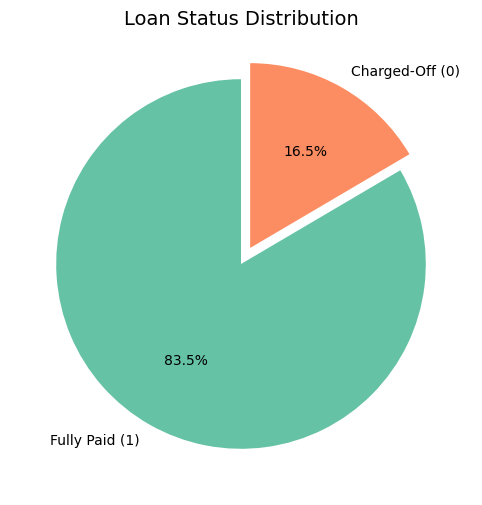

In [ ]:
# Plotting the distribution of the target variable

status_counts = df['loan_status'].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 6))
plt.pie(status_counts, labels=['Fully Paid (1)', 'Charged-Off (0)'], autopct='%1.1f%%',
        colors=['#66c2a5', '#fc8d62'], startangle=90, explode=(0, 0.1))
plt.title('Loan Status Distribution', fontsize=14)
plt.show()

Insights: 83.5% of loans are Fully Paid, while 16.5% are Charged-Off indicating that the majority of borrowers repay their loans, but a significant minority defaults (~1 in 6).

#### 3.4.2 Distribution of Interest Rate

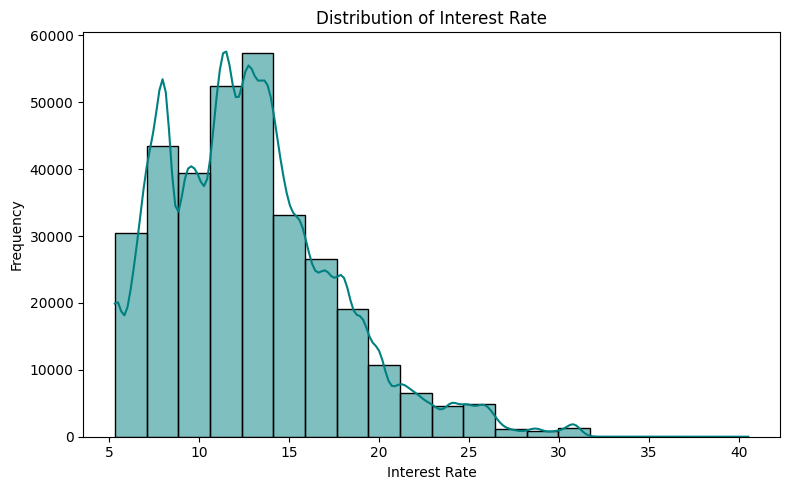

In [ ]:
# Plot distribution of Interest Rate
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='int_rate', bins=20, kde=True, color='teal')
plt.title('Distribution of Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Frequency')
plt.grid(False)
plt.tight_layout()
plt.show()

Insights: Interest rates are right-skewed, with a peak around 10–15%. A small number of loans have extremely high interest rates (>30%), which could indicate higher risk profiles or subprime borrowers.

#### 3.4.3 Loan Count by Purpose

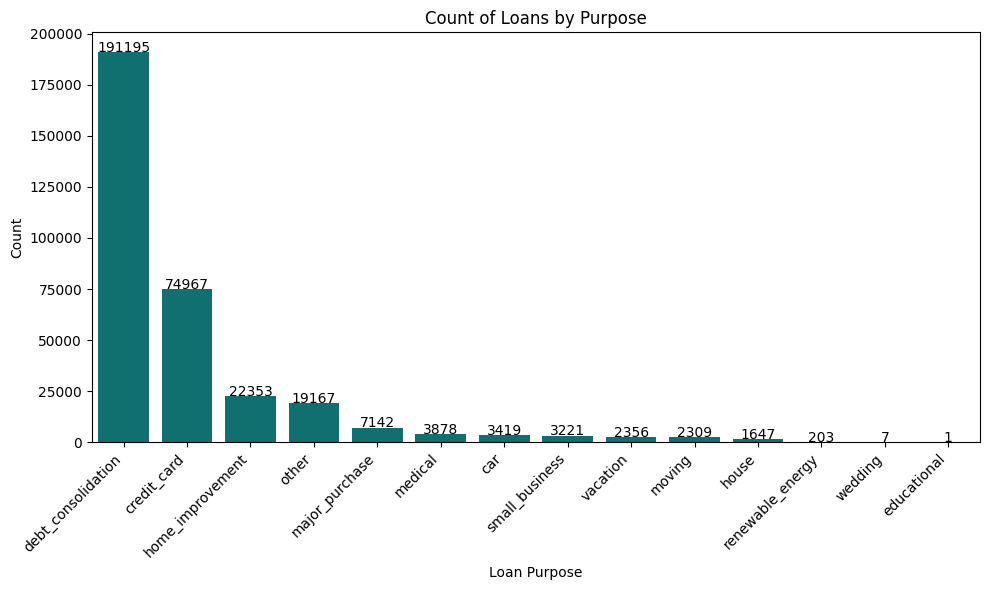

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='purpose', order=df['purpose'].value_counts().index, color='teal')

# Add data labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 50, int(height), ha="center", fontsize=10)

# Set titles and labels
plt.title('Count of Loans by Purpose')
plt.xlabel('Loan Purpose')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(False)
plt.tight_layout()
plt.show()

Insights: Debt consolidation is the most common loan purpose, followed by credit card and home improvement indicating that a large portion of borrowers are seeking to manage or reduce existing debt rather than finance new purchases.


### 3.5 Bivariate Analysis

#### 3.5.1 Charged-Off Rate by Purpose & Charged-Off Rate by Term of Loan

<ipython-input-12-d6f35ecb8d1e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=charged_off_rate, x=feature, y='charged_off_rate', palette='Set2')


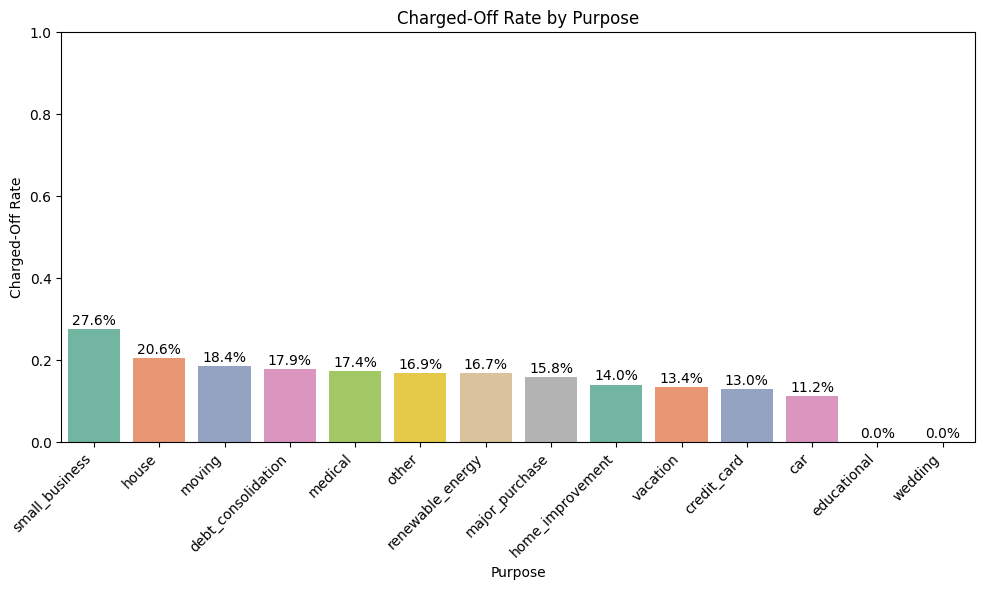

<ipython-input-12-d6f35ecb8d1e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=charged_off_rate, x=feature, y='charged_off_rate', palette='Set2')


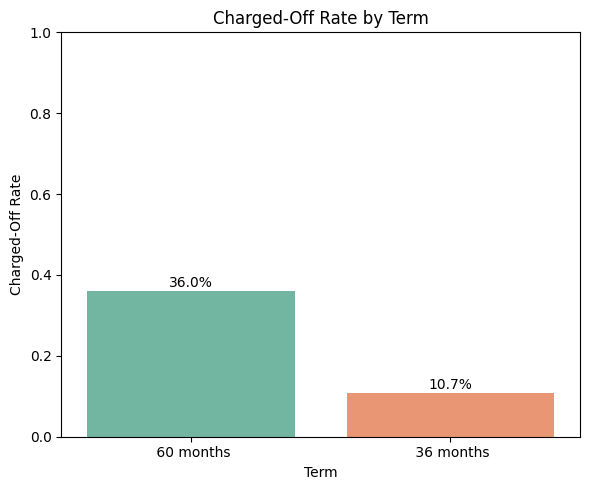

In [ ]:
features = ['purpose', 'term']

# Loop through each feature
for feature in features:
    # Calculate charged-off rate
    charged_off_rate = df.groupby(feature)['loan_status'].apply(lambda x: (x == 0).mean()).reset_index()
    charged_off_rate.rename(columns={'loan_status': 'charged_off_rate'}, inplace=True)
    charged_off_rate.sort_values(by='charged_off_rate', ascending=False, inplace=True)

    # Plot
    plt.figure(figsize=(10, 6) if feature == 'purpose' else (6, 5))
    ax = sns.barplot(data=charged_off_rate, x=feature, y='charged_off_rate', palette='Set2')

    # Add data labels
    for p in ax.patches:
        height = p.get_height()
        if not pd.isna(height):
            ax.text(p.get_x() + p.get_width()/2., height + 0.01, f"{height*100:.1f}%", ha="center", fontsize=10)

    # Customize
    plt.title(f'Charged-Off Rate by {feature.capitalize()}')
    plt.ylabel('Charged-Off Rate')
    plt.xlabel(feature.capitalize())
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right') if feature == 'purpose' else plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

Insights:

**Charged-Off Rate by Purpose** - The highest default rates occur in small businesses (27.6%), house (20.6%), and moving (18.4%) whereas car, educational and wedding loans show the lowest risk. This indicates that lending to small businesses is riskier than to individuals for personal or essential expenses.

**Charged-Off Rate by Term of Loan**: 60-month loans have a much higher charged-off rate than 36-month loans suggesting longer terms appear riskier, possibly due to borrower fatigue or increased chances of income disruption over time.

#### 3.5.2 Interest Rate by Loan Status

<ipython-input-13-522d8e2089c0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, x='loan_status', y='int_rate', palette='coolwarm')


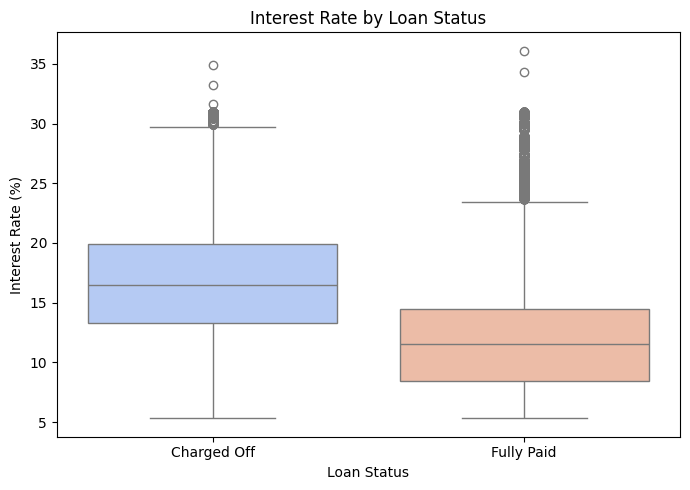

In [ ]:
plt.figure(figsize=(7, 5))
ax = sns.boxplot(data=df, x='loan_status', y='int_rate', palette='coolwarm')

plt.title('Interest Rate by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Interest Rate (%)')
plt.xticks([0, 1], ['Charged Off', 'Fully Paid'])
plt.tight_layout()
plt.show()

Insights: Charged-off loans generally have higher interest rates suggesting lenders are charging more to riskier borrowers, but this doesn’t prevent defaulting. This exhibits strong negative correlation between interest rate and repayment success.

Charged-Off loans has more extreme outliers with interest rates going well above 30% indicating many high-interest loans are associated with borrowers who eventually defaulted.

### 3.6 Multivariate Analysis

#### 3.6.1 Charged-Off Rate by Loan Purpose and Term

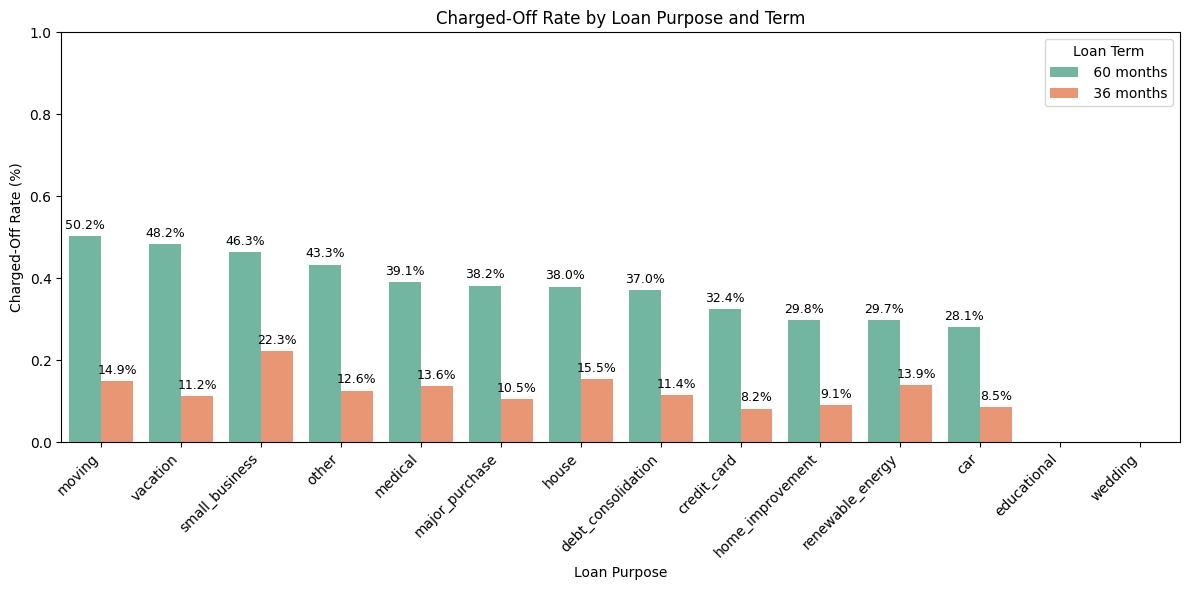

In [ ]:
# Calculate charged-off rate by purpose and term
grouped = df.groupby(['purpose', 'term'])['loan_status'].apply(lambda x: (x == 0).mean()).reset_index()
grouped.rename(columns={'loan_status': 'charged_off_rate'}, inplace=True)
grouped.sort_values(by='charged_off_rate', ascending=False, inplace=True)

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=grouped, x='purpose', y='charged_off_rate', hue='term', palette='Set2')

for container in ax.containers:
    labels = [f"{h.get_height()*100:.1f}%" if h.get_height() > 0 else "" for h in container]
    ax.bar_label(container, labels=labels, label_type='edge', fontsize=9, padding=3)

plt.title('Charged-Off Rate by Loan Purpose and Term')
plt.xlabel('Loan Purpose')
plt.ylabel('Charged-Off Rate (%)')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Loan Term')
plt.tight_layout()
plt.show()

Insights: Across all purposes, 60-month terms consistently exhibit higher charged-off rates than 36-month terms with some extreme cases such as moving (50.2% vs 0.0%), and vacation (48.2% vs 11.2%). This indicates term length is a critical factor regardless of loan purpose.

#### 3.6.2 FICO Score vs Interest Rate by Loan Status

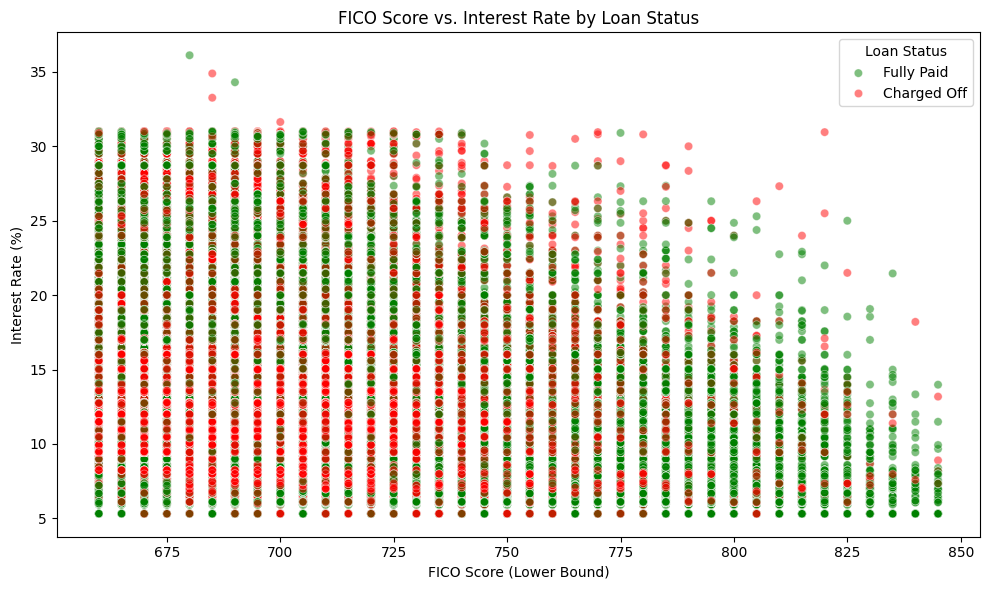

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='fico_range_low',
    y='int_rate',
    hue='loan_status',
    palette={1: 'green', 0: 'red'},
    alpha=0.5
)
plt.title('FICO Score vs. Interest Rate by Loan Status')
plt.xlabel('FICO Score (Lower Bound)')
plt.ylabel('Interest Rate (%)')
plt.legend(title='Loan Status', labels=['Fully Paid', 'Charged Off'])
plt.tight_layout()
plt.show()

Insights: Clear inverse relationship - as FICO scores increase, interest rates decrease. Charged-off loans are clustered at lower FICO scores and higher interest rates which shows that credit score is a strong predictor of loan pricing and risk.

_____
# 4. Data Cleaning

### 4.1 Removing features with unique values

In [34]:
# Removing the feature 'id'
df.drop(columns=['id'], inplace = True, axis = 1)

In [35]:
# Removing the feature from the list storing categorical features
categorical.remove('id')

**Insight:** The feature 'id' was removed from the dataset as it contains unique identifiers for each record. Since it does not carry any predictive value and can introduce noise or overfitting, it was excluded from model training

### 4.2 Handling Null Values

In [36]:
# Checking for missing values in the dataset
df.isnull().sum()

issue_d                        0
sub_grade                      0
term                           0
home_ownership               826
fico_range_low                 0
total_acc                      0
pub_rec                        0
revol_util                     0
annual_inc                     0
int_rate                       0
dti                            0
purpose                        0
mort_acc                       0
loan_amnt                      0
application_type               0
installment                    0
verification_status            0
pub_rec_bankruptcies           0
addr_state                     0
initial_list_status            0
fico_range_high                0
revol_bal                      0
open_acc                       0
emp_length                     0
loan_status                 1412
time_to_earliest_cr_line       0
dtype: int64

**Insight:** From the above output, the predictive feature 'home_ownership' and the target feature 'loan_status' are the only two features in the dataset with null values. Each of these null values will be handled seperately.

#### 4.2(a) Handling the null values in the target variable - 'loan_status'

In [37]:
# Dropping all the rows with the target variable having missing values
df.dropna(subset=['loan_status'], inplace = True)

**Insight:** Rows with missing values in the loan_status column (~0.42% of the data) were dropped, as the target variable is essential for supervised learning. Imputing target values is inappropriate and could lead to data leakage.

#### 4.2(b) - Handling the null values in the feature 'home_ownership'

In [38]:
# Check the distribution of the target variable with missing values in the feature 'home_ownership'
df[df['home_ownership'].isnull()]['loan_status'].value_counts(normalize=True)

loan_status
1.0    0.843826
0.0    0.156174
Name: proportion, dtype: float64

In [39]:
# Check the overall distribution of the target variable
df['loan_status'].value_counts(normalize=True)

loan_status
1.0    0.834666
0.0    0.165334
Name: proportion, dtype: float64

In [40]:
# Fill the unknown values with the mode of the feature
df['home_ownership'] = df['home_ownership'].fillna(df['home_ownership'].mode()[0])

Insight: We observed that the missingness in home_ownership was minimal (only 0.25% of the total data) and that the loan approval distribution for missing values closely matched the overall distribution. Therefore, to maintain dataset simplicity without introducing significant bias, we imputed the missing home_ownership values with the most frequent category, "MORTGAGE". This approach preserves the overall distribution while minimising the impact on model performance.

In [41]:
# Final Check for missing values in the dataset
df.isnull().sum()

issue_d                     0
sub_grade                   0
term                        0
home_ownership              0
fico_range_low              0
total_acc                   0
pub_rec                     0
revol_util                  0
annual_inc                  0
int_rate                    0
dti                         0
purpose                     0
mort_acc                    0
loan_amnt                   0
application_type            0
installment                 0
verification_status         0
pub_rec_bankruptcies        0
addr_state                  0
initial_list_status         0
fico_range_high             0
revol_bal                   0
open_acc                    0
emp_length                  0
loan_status                 0
time_to_earliest_cr_line    0
dtype: int64

**Insight:** As observed from the above output, all the missing values in the dataset have been handled.

### 4.3 Handling Duplicate Values

In [42]:
# Checking for duplicate values in the dataset
df.duplicated().sum()

np.int64(0)

**Insight:** There are no duplicate values present in the dataset as seen from the output above

### 4.4 Handling Outlier Values in Continuous Features

In [43]:
# Printing all the continuous features in the dataset
print(continuous)

['fico_range_low', 'fico_range_high', 'annual_inc', 'int_rate', 'dti', 'installment', 'revol_util', 'loan_amnt', 'time_to_earliest_cr_line']


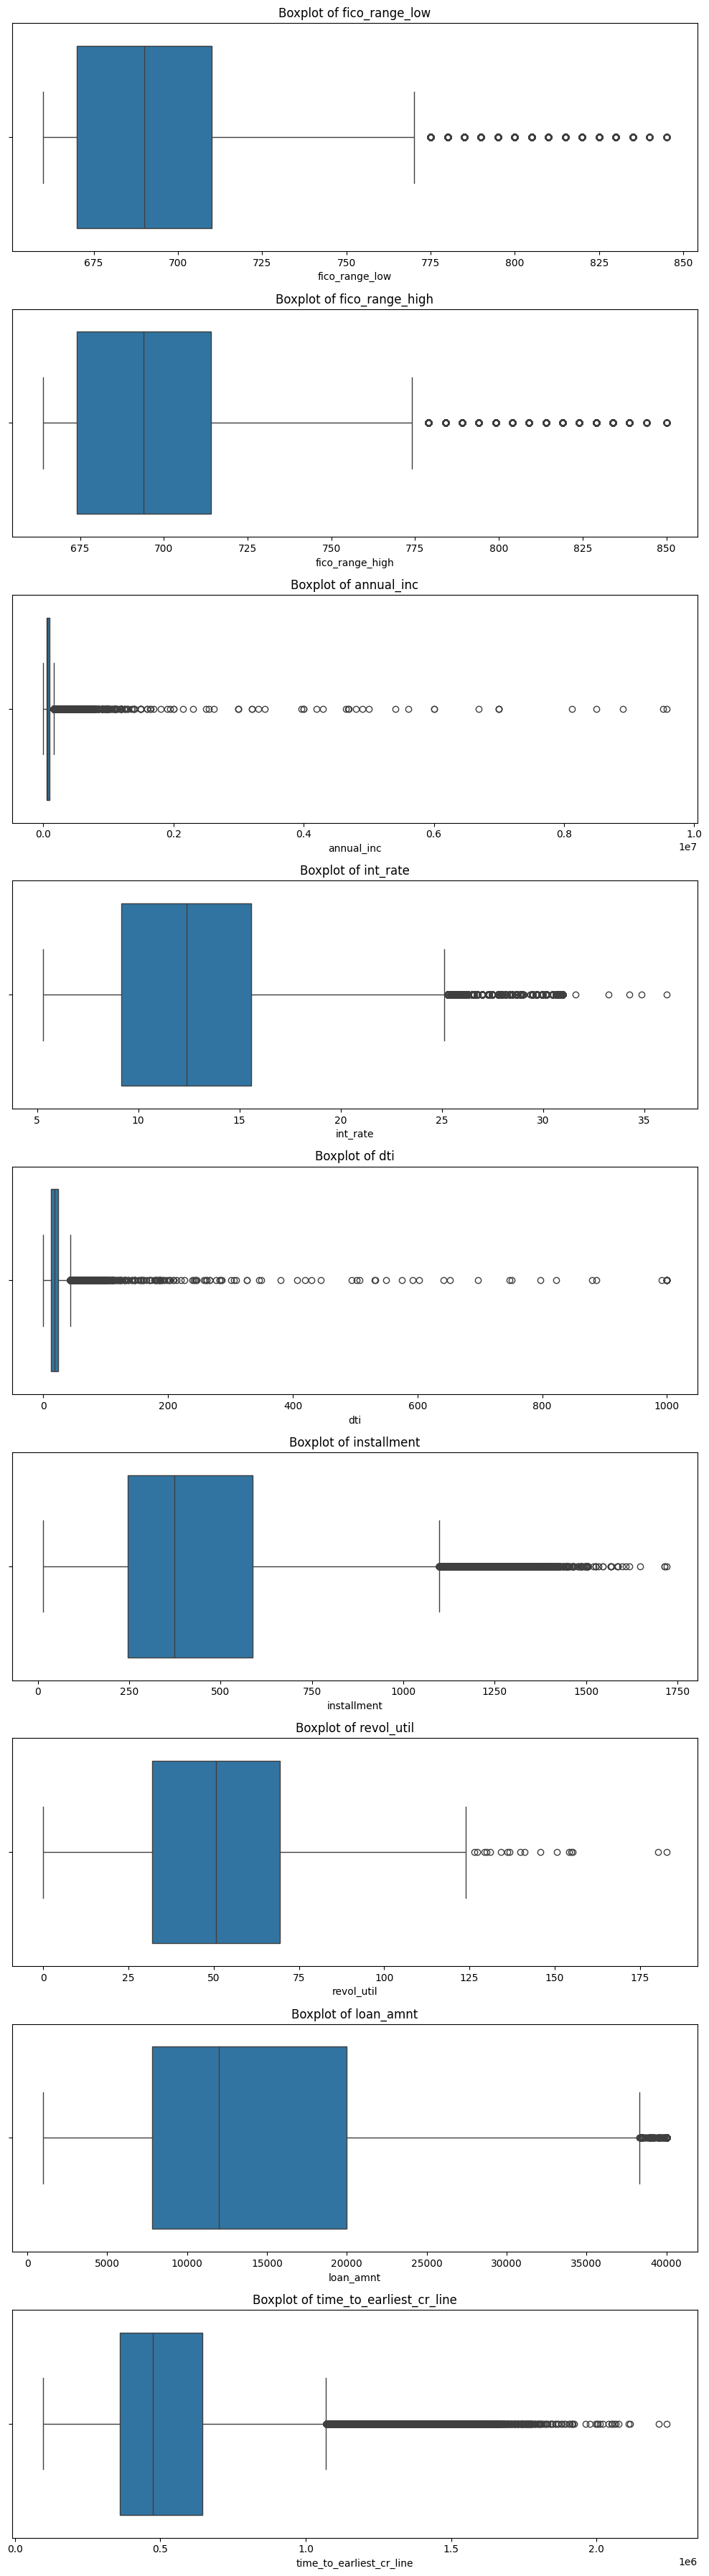

In [44]:
# Plotting the boxplots for the continuous columns to check for outliers
plt.figure(figsize=(10, len(continuous) * 4))
for i, col in enumerate(continuous):
    plt.subplot(len(continuous), 1, i + 1)
    sns.boxplot(x = df[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
plt.tight_layout()
plt.show()

In [45]:
# Perform outlier detection and removal on certain features using IQR method
outlier_cols = ['annual_inc', 'int_rate', 'installment', 'time_to_earliest_cr_line']

for feat in outlier_cols:
    q1 = df[feat].quantile(0.25)
    q3 = df[feat].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 3 * iqr
    upper_bound = q3 + 3 * iqr
    df = df[(df[feat] >= lower_bound) & (df[feat] <= upper_bound)]

In [46]:
# Perform Domain based capping on other features where unrealistic values are observed
df['dti'] = np.where(df['dti'] > 60, 60, df['dti'])
df['revol_util'] = np.where(df['revol_util'] > 100, 100, df['revol_util'])

**Insights:** From the box plot, the main features that suffered from outliers were {annual_inc, int_rate, installment, time_to_earliest_cr_line, dti, revol_util}. To handle these features, two techniques were employed:


1.   *IQR Method:* The outliers in the first four features with well-distributed numerical ranges were handled using the IQR method, which removes extreme values based on statistical thresholds.
2.   *Domain-based Capping:* To features like 'dti' and 'revol_util', domain-based capping was applied where values beyond realistic limits were capped based on practical knowledge rather than statistical spread.

  *   dti: capped at 60 as values above are considered unrealistic.
  *   revol_util: capped at 100 since utilization rates logically cannot exceed 100%.

___

# 5. Data Transformation

### 5.1 Extracting Date-Based Features

In [47]:
# Converting the feature to a date-time datatype
df['issue_d'] = pd.to_datetime(df['issue_d'])

In [48]:
# Extracting the year and month for each 'issue_d' instance
df['issue_year'] = df['issue_d'].dt.year
df['issue_month'] = df['issue_d'].dt.month

In [49]:
# Dropping the original 'issue_d' column
df.drop(columns = ['issue_d'], inplace = True)

In [50]:
# Removing the 'issue_d' column from the list of categorical features
categorical.remove('issue_d')

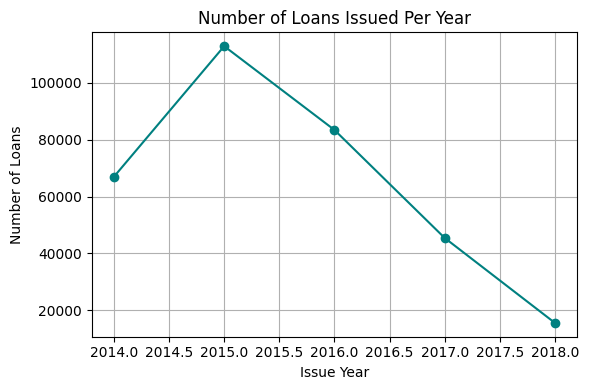

In [ ]:
# Timeline Line Plot for the number of loans issued per year
# Count number of loans per year
issue_year_counts = df['issue_year'].value_counts().sort_index()

# Plot
plt.figure(figsize=(6, 4))
plt.plot(issue_year_counts.index, issue_year_counts.values, marker='o', linestyle='-', color='teal')
plt.title("Number of Loans Issued Per Year")
plt.xlabel("Issue Year")
plt.ylabel("Number of Loans")
plt.grid(True)
plt.tight_layout()
plt.show()

**Insight:** From the issue_d column, two new features — issue_year and issue_month — were extracted, with the aim that they could help  capture seasonal or temporal patterns in loan issuance that may influence loan performance. The exact day (d) within a month often introduces unnecessary granularity that doesn't add predictive power and may even add noise, which might not help the model generalise better.

### 5.2 Converting Loan Term from Months to Years

In [53]:
# Converting the 'term' feature to a numerical value based on the number of years from months
df['term'] = df['term'].str.strip()
df['term'] = df['term'].map({'60 months': 5.0, '36 months': 3.0})

In [54]:
# Removing the 'term' column from the list of categorical features and adding it to the list of discrete features
categorical.remove('term')
discrete.append('term')

In [55]:
# Display the feature 'term' to check the changes
df['term'].head()

0    5.0
1    5.0
2    3.0
3    5.0
4    3.0
Name: term, dtype: float64

**Insight:** The 'term' column was cleaned and mapped from a categorical variable to a discrete numerical feature, representing loan duration in years. This approach preserves the information, avoiding the loss of meaningful temporal details that could occur during label encoding.

### 5.3 Converting Categorical Features to Numerical

In [56]:
# Display all the categorical features in the dataset
df[categorical].head()

,sub_grade,home_ownership,purpose,application_type,verification_status,addr_state,initial_list_status
0,D1,MORTGAGE,credit_card,Individual,Verified,AR,f
1,C4,MORTGAGE,credit_card,Individual,Verified,VT,f
2,A4,RENT,debt_consolidation,Individual,Not Verified,TX,w
3,D1,MORTGAGE,debt_consolidation,Individual,Verified,IN,f
4,C3,MORTGAGE,vacation,Individual,Verified,LA,f


In [57]:
# Convert the categorical variables into numerical features using Label Encoding
label_encoders = {}

for col in categorical:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [58]:
df.head()

,sub_grade,term,home_ownership,fico_range_low,total_acc,pub_rec,revol_util,annual_inc,int_rate,dti,...,addr_state,initial_list_status,fico_range_high,revol_bal,open_acc,emp_length,loan_status,time_to_earliest_cr_line,issue_year,issue_month
0,15,5.0,1,660.0,18.0,0.0,86.8,40440.0,16.99,15.16,...,2,0,664.0,17264.0,11.0,2.0,1.0,478656.0,2014,1
1,13,5.0,1,740.0,26.0,0.0,100.0,59000.0,15.61,16.74,...,46,0,744.0,6725.0,8.0,3.0,1.0,541728.0,2014,1
2,3,3.0,4,700.0,47.0,0.0,11.4,40000.0,7.90,20.34,...,43,1,704.0,7613.0,27.0,1.0,1.0,657590.4,2014,1
3,15,5.0,1,665.0,26.0,0.0,56.2,70000.0,16.99,23.15,...,15,0,669.0,14173.0,9.0,11.0,1.0,328838.4,2014,1
4,12,3.0,1,700.0,15.0,1.0,67.1,120000.0,14.98,17.88,...,18,0,704.0,2549.0,8.0,2.0,1.0,305164.8,2014,1


**Insight:** From the output above, it is evident that all the categorical features have been converted to numerical values, making the dataset suitable for machine learning models that require numerical input.

### 5.4 Splitting the Dataset into Features and Targets

In [59]:
# Defining the feature set 'X' and the target variable 'y'
X = df.drop(columns = [TARGET_VARIABLE])
y = df[TARGET_VARIABLE]

In [60]:
# Display the feature set 'X'
X.head()

,sub_grade,term,home_ownership,fico_range_low,total_acc,pub_rec,revol_util,annual_inc,int_rate,dti,...,pub_rec_bankruptcies,addr_state,initial_list_status,fico_range_high,revol_bal,open_acc,emp_length,time_to_earliest_cr_line,issue_year,issue_month
0,15,5.0,1,660.0,18.0,0.0,86.8,40440.0,16.99,15.16,...,0.0,2,0,664.0,17264.0,11.0,2.0,478656.0,2014,1
1,13,5.0,1,740.0,26.0,0.0,100.0,59000.0,15.61,16.74,...,0.0,46,0,744.0,6725.0,8.0,3.0,541728.0,2014,1
2,3,3.0,4,700.0,47.0,0.0,11.4,40000.0,7.90,20.34,...,0.0,43,1,704.0,7613.0,27.0,1.0,657590.4,2014,1
3,15,5.0,1,665.0,26.0,0.0,56.2,70000.0,16.99,23.15,...,0.0,15,0,669.0,14173.0,9.0,11.0,328838.4,2014,1
4,12,3.0,1,700.0,15.0,1.0,67.1,120000.0,14.98,17.88,...,0.0,18,0,704.0,2549.0,8.0,2.0,305164.8,2014,1


In [61]:
# Convert the target variable 'y' to integer datatype
y = y.astype('int')
y.head()

0    1
1    1
2    1
3    1
4    1
Name: loan_status, dtype: int64

### 5.5 Normalizing the values

In [62]:
# Scaling the features using StandardScaler
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)
X_sc = pd.DataFrame(X_sc, columns = X.columns)
X_sc.head()

,sub_grade,term,home_ownership,fico_range_low,total_acc,pub_rec,revol_util,annual_inc,int_rate,dti,...,pub_rec_bankruptcies,addr_state,initial_list_status,fico_range_high,revol_bal,open_acc,emp_length,time_to_earliest_cr_line,issue_year,issue_month
0,0.719948,1.842572,-0.984350,-1.118178,-0.585274,-0.366217,1.477742,-0.871918,0.876164,-0.378398,...,-0.365338,-1.393751,-1.406595,-1.118158,0.079104,-0.126281,-0.928292,-0.165836,-1.329733,-1.536842
1,0.407177,1.842572,-0.984350,1.363890,0.072249,-0.366217,2.016359,-0.379550,0.584567,-0.198258,...,-0.365338,1.514437,-1.406595,1.363854,-0.462184,-0.660703,-0.693277,0.103543,-1.329733,-1.536842
2,-1.156680,-0.542720,1.128555,0.122856,1.798246,-0.366217,-1.598904,-0.883591,-1.044572,0.212186,...,-0.365338,1.316151,0.710937,0.122848,-0.416576,2.723969,-1.163306,0.598387,-1.329733,-1.536842
3,0.719948,1.842572,-0.984350,-0.963049,0.072249,-0.366217,0.229130,-0.087737,0.876164,0.532560,...,-0.365338,-0.534514,-1.406595,-0.963032,-0.079651,-0.482562,1.186840,-0.805701,-1.329733,-1.536842
4,0.250791,-0.542720,-0.984350,0.122856,-0.831845,1.184857,0.673897,1.238686,0.451446,-0.068284,...,-0.365338,-0.336228,-1.406595,0.122848,-0.676666,-0.660703,-0.928292,-0.906810,-1.329733,-1.536842


**Insight:** From the output above, we can see that standardisation has been applied across the dataset, which ensures that all features are on the same scale, preventing models from being biased toward variables with larger magnitudes.

____

# 6. Train-Test Splitting

In [63]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sc, y, test_size = 0.2, random_state = 42)

In [64]:
# Print the shapes of the training and testing sets
print(f"Training set shape => Features: {X_train.shape}, Target: {y_train.shape}")
print(f"Testing set shape => Features: {X_test.shape}, Target: {y_test.shape}")

Training set shape => Features: (259464, 26), Target: (259464,)
Testing set shape => Features: (64866, 26), Target: (64866,)


___

# 7. Feature Engineering

### 7.1 Creating Average FICO Score Feature

In [65]:
# Creating a new feature 'fico_score_avg' by taking the average of 'fico_range_low' and 'fico_range_high'
X_train['fico_score_avg'] = (X_train['fico_range_low'] + X_train['fico_range_high']) / 2
X_test['fico_score_avg'] = (X_test['fico_range_low'] + X_test['fico_range_high']) / 2

In [67]:
X_train[['fico_range_low', 'fico_range_high', 'fico_score_avg']].head()

,fico_range_low,fico_range_high,fico_score_avg
104561,-0.032273,-0.032277,-0.032275
87050,0.433114,0.433100,0.433107
207864,-0.807920,-0.807906,-0.807913
320633,-0.963049,-0.963032,-0.963040
241972,1.829278,1.829232,1.829255


In [68]:
# Dropping the original 'fico_range_low' and 'fico_range_high' features from the training and testing sets
X_train.drop(columns = ['fico_range_low', 'fico_range_high'], axis = 1, inplace = True)
X_test.drop(columns = ['fico_range_low', 'fico_range_high'], axis = 1, inplace = True)

In [69]:
# Removing the features 'fico_range_low' and 'fico_range_high' from the list of continuous features and adding 'fico_score_avg'
continuous.remove('fico_range_low')
continuous.remove('fico_range_high')
continuous.append('fico_score_avg')

**Insight:** A new feature 'fico_score_avg' was created by averaging fico_range_low and fico_range_high, which provides a single representative credit score for each borrower, simplifying the input while retaining the core information about their creditworthiness.

_____
# 8. Feature Selection

### 8.1 Handling Multicollinearity: Identifying and Removing Redundant Features

In [70]:
# Calculate the Variance Inflation Factor (VIF) for each feature in the training set
vif = pd.DataFrame()
vif["feature"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

                     feature        VIF
11                 loan_amnt  65.837520
13               installment  57.466549
7                   int_rate  33.537928
0                  sub_grade  33.310350
1                       term   7.180777
3                  total_acc   2.545045
19                  open_acc   2.339010
15      pub_rec_bankruptcies   1.812847
6                 annual_inc   1.787870
4                    pub_rec   1.778281
24            fico_score_avg   1.773582
5                 revol_util   1.723695
10                  mort_acc   1.649075
18                 revol_bal   1.451521
8                        dti   1.441942
2             home_ownership   1.377153
22                issue_year   1.263842
21  time_to_earliest_cr_line   1.209207
14       verification_status   1.142999
9                    purpose   1.126779
17       initial_list_status   1.117870
12          application_type   1.106694
20                emp_length   1.071082
23               issue_month   1.039158


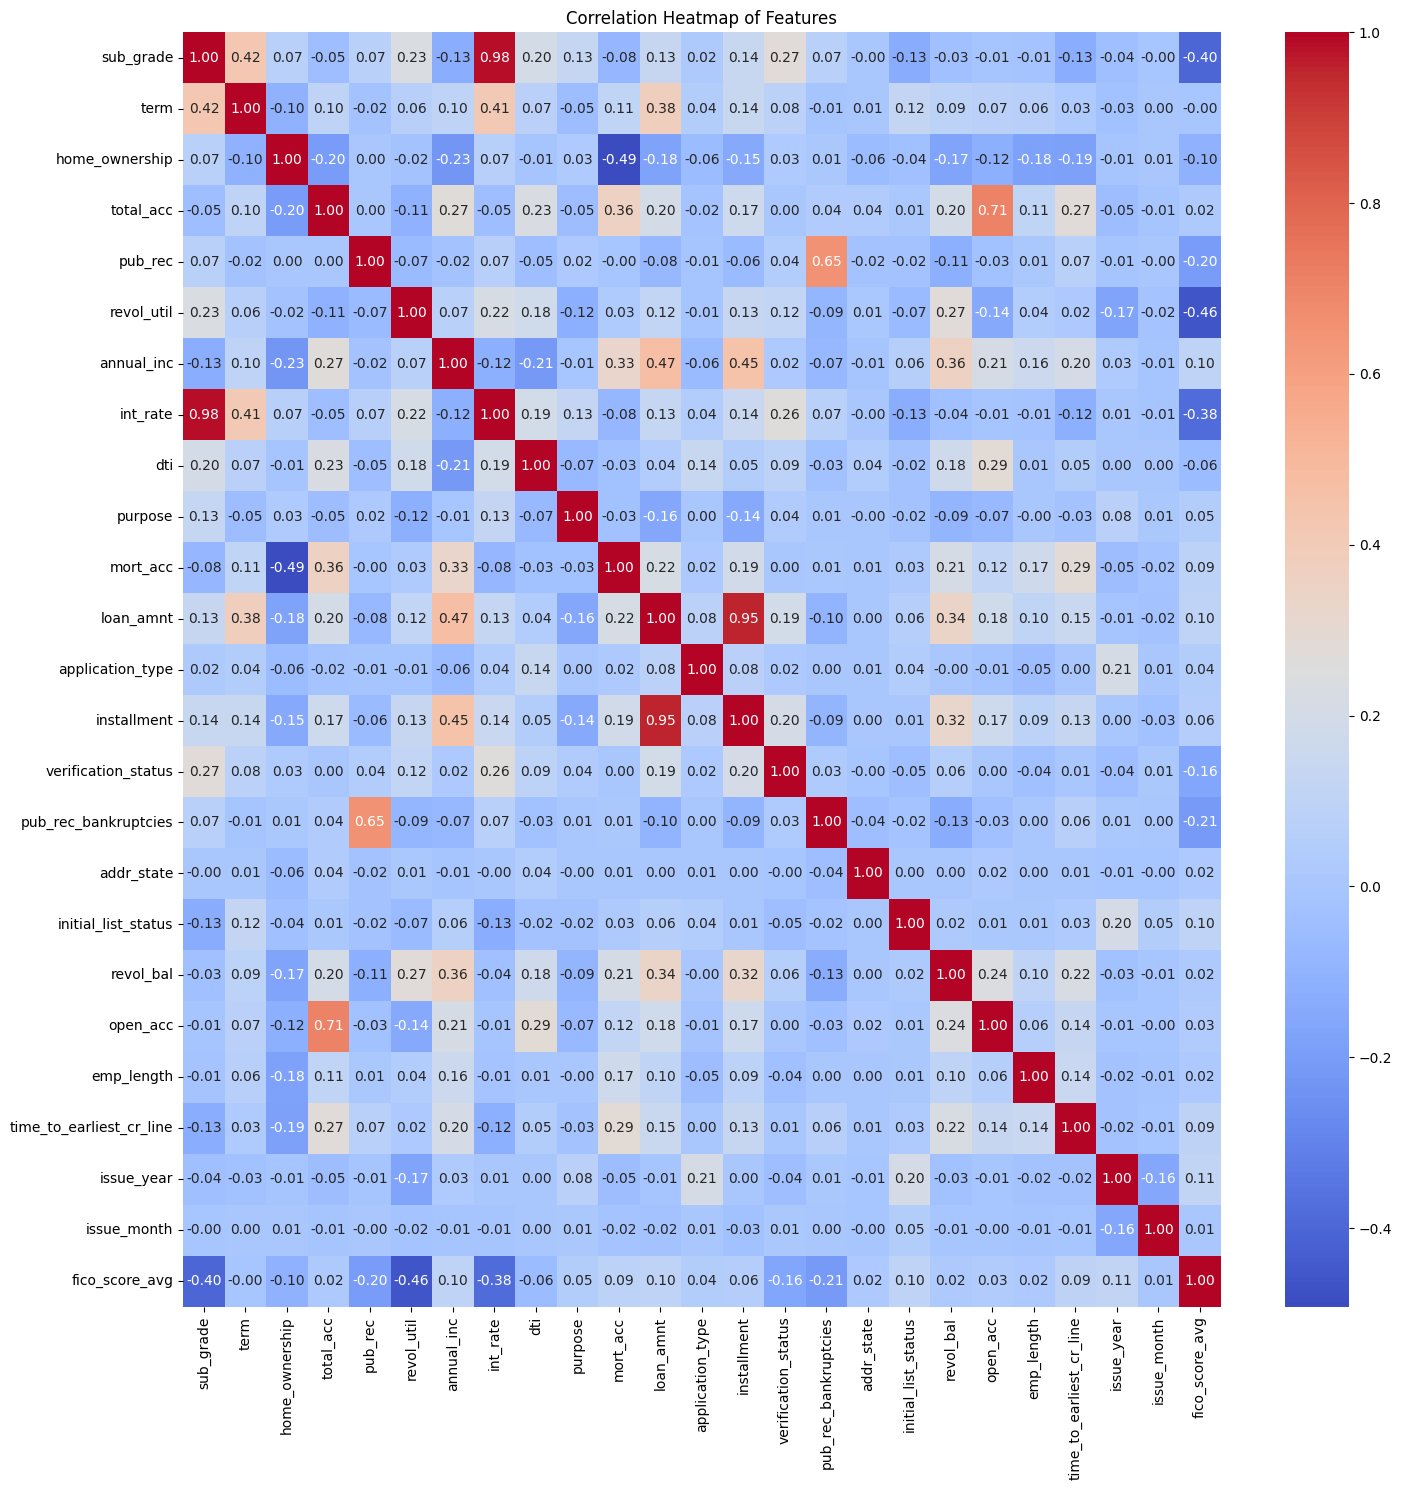

In [72]:
# Plotting a correlation heatmap to visualize the correlation between features
plt.figure(figsize=(15, 15))
sns.heatmap(X_train.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Features')
plt.tight_layout()
plt.show()

**Insights:** From the above outputs, the VIF scores for features {loan_amnt, installment, int_rate, sub_grade} are all greater than 10 which indicates that there is a high measure of multicollinearity in the dataset. Additionally, from the correlation plot it is evident that:

* loan_amnt and installment both have a correlation of 0.95 to each other
* int_rate and sub_grade show a 98% correlation to each other

It is important to address multicollinearity is important because it can lead to unstable and unreliable model coefficients.

In [73]:
# Dropping the features with high VIF values from the training and testing sets
X_train.drop(columns = ['installment', 'sub_grade'], axis = 1, inplace = True)
X_test.drop(columns = ['installment', 'sub_grade'], axis = 1, inplace = True)

In [74]:
# Removingn the features 'installment' and 'sub_grade' from the list of continuous and categorical features respectively
continuous.remove('installment')
categorical.remove('sub_grade')

In [75]:
# Calculate the Variance Inflation Factor (VIF) again after dropping the features with high VIF values
vif = pd.DataFrame()
vif["feature"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

In [76]:
print(vif.sort_values(by="VIF", ascending=False))

                     feature       VIF
2                  total_acc  2.542552
17                  open_acc  2.338419
13      pub_rec_bankruptcies  1.812649
6                   int_rate  1.796112
5                 annual_inc  1.784414
3                    pub_rec  1.777720
10                 loan_amnt  1.745279
22            fico_score_avg  1.744478
4                 revol_util  1.723514
9                   mort_acc  1.648118
0                       term  1.507449
16                 revol_bal  1.450120
7                        dti  1.435305
1             home_ownership  1.376722
19  time_to_earliest_cr_line  1.208352
20                issue_year  1.197520
12       verification_status  1.136980
15       initial_list_status  1.117496
8                    purpose  1.113214
11          application_type  1.101044
18                emp_length  1.070888
21               issue_month  1.038939
14                addr_state  1.010416


**Insight:** Based on correlation and VIF analysis, features 'installment' and 'sub_grade' were dropped. The feature 'installment' is nearly redundant with 'loan_amnt' (correlation: 0.95) as it’s derived from the loan amount and interest, while 'sub_grade' is highly correlated with 'int_rate' (0.98) and essentially encodes the same information. Retaining features 'loan_amnt' and 'int_rate' preserves interpretability and reduces redundancy,which could help improve the overall stability of the model.

### 8.2 Mutual Information Gain

In [77]:
# Feature Selection using Mutual Information
mutual_info = pd.Series(mutual_info_classif(X_train, y_train, random_state=42), index=X_train.columns)
feat_sel = pd.DataFrame({'Feature': X_train.columns, 'Information_Gain': mutual_info}).sort_values(by = 'Information_Gain', ascending = False)
feat_sel

,Feature,Information_Gain
int_rate,int_rate,0.073686
term,term,0.059397
home_ownership,home_ownership,0.020755
initial_list_status,initial_list_status,0.020379
verification_status,verification_status,0.018421
loan_amnt,loan_amnt,0.015870
fico_score_avg,fico_score_avg,0.014818
pub_rec_bankruptcies,pub_rec_bankruptcies,0.013887
pub_rec,pub_rec,0.011736
dti,dti,0.011329


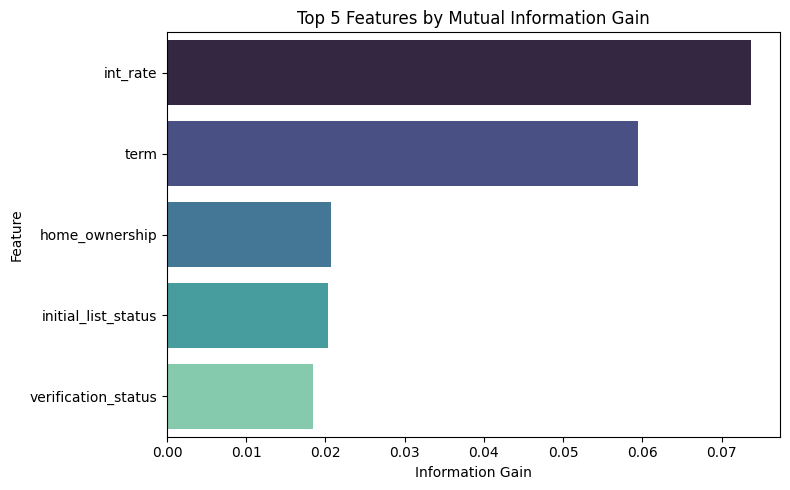

In [79]:
# Plotting the top 5 features based on Mutual Information Gain
plt.figure(figsize=(8, 5))
sns.barplot(x = 'Information_Gain', y = 'Feature', data = feat_sel.head(5), hue = 'Feature', palette = 'mako', legend = False)
plt.title('Top 5 Features by Mutual Information Gain')
plt.xlabel('Information Gain')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

**Insights:** From the results of the mutual information gain, it was observed that:
* Features like 'int_rate', 'term' and 'home_ownership' showed the highest information gain, indicating they contribute most to predicting the target.
* Lower-ranked features like 'revol_bal' and 'total_acc' offer minimal predictive value and could be considered for removal during feature selection.

### 8.3 Forward Selection

In [ ]:
# Performing feature selection using Foward Selection
model = DecisionTreeClassifier()
sfs = SFS(model, k_features = 15, forward = True, floating = False, scoring = 'f1', cv = 5).fit(X_train, y_train)

In [ ]:
# Display the top 15 features selected by the forward selection method
list(sfs.k_feature_names_)

['term',
 'home_ownership',
 'pub_rec',
 'int_rate',
 'dti',
 'purpose',
 'mort_acc',
 'application_type',
 'verification_status',
 'pub_rec_bankruptcies',
 'initial_list_status',
 'time_to_earliest_cr_line',
 'issue_year',
 'issue_month',
 'fico_score_avg']

**Insights:** Based on forward selection, the 15 features shown above were chosen for their contribution to model performance, as they provided the best balance of f1-scores in cross-validation, optimising the predictive power while reducing complexity.

### 8.4 Backward Selection

In [ ]:
# Performing feature selection using Backward Selection
sfs = SFS(model, k_features = 15, forward = False, floating = False, scoring = 'f1', cv = 5).fit(X_train, y_train)

In [ ]:
# Display the top 15 features selected by the backward selection method
list(sfs.k_feature_names_)

['term',
 'home_ownership',
 'total_acc',
 'annual_inc',
 'int_rate',
 'dti',
 'mort_acc',
 'loan_amnt',
 'addr_state',
 'revol_bal',
 'open_acc',
 'emp_length',
 'time_to_earliest_cr_line',
 'issue_month',
 'fico_score_avg']

**Insights:** Based on backward selection, the 15 features in the output above were selected for their ability to maximise the performance metric during cross-validation, ensuring the model includes only the most impactful variables while reducing overfitting.



### 8.5 Final Set of Features Selected

In [ ]:
# Selecting the 15 - best features based on the feature selection results
features_seleced = ['int_rate', 'term', 'home_ownership', 'dti', 'fico_score_avg', 'annual_inc', 'pub_rec_bankruptcies', 'verification_status',
                    'initial_list_status', 'mort_acc', 'purpose', 'application_type', 'time_to_earliest_cr_line', 'issue_year', 'loan_amnt']


**Insights:** Based on both the filter (Information Gain) and wrapper (Forward & Backward Selection) methods, the following 15 features shown above were selected for the final model.These features were chosen for their strong predictive power, balancing performance and information gain. The filter method helped identify key features based on their individual contribution, while the wrapper methods further refined the selection by evaluating feature combinations and model performance.

In [ ]:
# Creating the new training and testing sets with the selected features
X_train = X_train[features_seleced]
X_test = X_test[features_seleced]

____
# 9. Model Building

In this project, we aim to evaluate and compare the performance of two machine learning models applied to our dataset. To guide this comparison, we formulate the following statistical hypotheses:

*   **Null Hypothesis (Ho):** There is no significant difference in the mean F1-scores of the Decision Tree and Gradient Boosting models.
*   **Alternate Hypothesis (Ha):** The mean scores of the two models are significantly different.



### 9.1 Decision Tree Model

In [ ]:
# Defining the first model - Decision Tree
dt_model = DecisionTreeClassifier(random_state = 42)

In [ ]:
# Defining the hyperparameters for tuning
param_grid_dt = {
    'max_depth': [3, 5, 10, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced'],
}

**Insight**: The selected hyperparameters help control the tree's complexity, improve generalisation and handle class imbalance:

*   *max_depth:* Limits the tree growth to prevent overfitting; deeper trees fit more but increases the risk of memorsiation.
*   *min_samples_split:* Controls when a node should be split; higher values lead to simpler trees.
*   *min_samples_leaf:* Ensures leaves have enough data points; helps smooth predictions and reduce variance.
*   *criterion:* Compares Gini impurity vs. entropy (information gain) to find best split quality.
*   *max_features:* Reduces overfitting by limiting the number of features considered at each split.
*   *class_weight:* Addresses class imbalance by weighting the minority class more heavily during training.

Together, these parameters optimise the decision tree model's performance, balances the overall tradeoff between bias and variance and improve results on imbalanced datasets like the one being used.



In [ ]:
# Use GridSearchCV with 5-fold Cross-Validation
grid_dt = GridSearchCV(dt_model, param_grid_dt, cv = 5, scoring = 'f1', n_jobs=-1)
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10, 20],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4, 10],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='f1')

In [ ]:
# Display the best model parameters
print("Best parameters for Decision Tree:", grid_dt.best_params_)

Best parameters for Decision Tree: {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


**Insight:** After performing hyperparameter tuning using GridSearchCV with 5-fold cross-validation, the best parameters for the Decision Tree model were found to be:

{

  'class_weight': None, => No weighting is applied to the classes

  'criterion': 'gini', => The tree splits are chosen based on the Gini impurity, a measure of how "pure" a node is.

  'max_depth': 5, => The tree will grow to a maximum depth of 5 levels, preventing  overfitting by limiting the complexing of the tree.

  'max_features': None, => The model considers all features when choosing the best split at each node.

  'min_samples_leaf': 1, => A leaf node must have at least 1 sample.

  'min_samples_split': 2 => A node must have at least 2 samples to be split.

}.

This configuration yielded the highest average cross-validated performance for this model.

In [ ]:
# Selecting the Decision Tree model with the best parameters
best_dt = grid_dt.best_estimator_

In [ ]:
# Stratified 5-fold Cross Validation
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

**Insight:** To obtain a more stable estimate of model performance, *Stratified 5-fold Cross Validation* has been performed, such that the variance is reduced from a single train-test split. Furthermore,  to ensure that each fold preserves the original class distribution, which is important for imbalanced datasets, we opted for Stratified Cross-Validation instead of standard Cross-Validation.

In [ ]:
# Calculating the accuracy scores for the model using cross-validation
acc_scores_dt = cross_val_score(best_dt, X_train, y_train, cv = skf, scoring = 'accuracy')

In [ ]:
# Calculating the F1-scores for the model using cross-validation
f1_scores_dt = cross_val_score(best_dt, X_train, y_train, cv = skf, scoring = 'f1')

In [ ]:
# Printing the accuracy scores for each fold and the mean accuracy
print("Stratified K-Fold Accuracy Scores for Decision Tree:", acc_scores_dt)
print("Mean Accuracy for Decision Tree:", acc_scores_dt.mean())

Stratified K-Fold Accuracy Scores for Decision Tree: [0.84791783 0.84838032 0.84658817 0.84745534 0.84905188]
Mean Accuracy for Decision Tree: 0.8478787083108588


In [ ]:
# Printing the F1-scores for each fold and the mean F1-score
print("Stratified K-Fold F1 scores for Decision Tree:", f1_scores_dt)
print("Mean F1 score for Decision Tree:", f1_scores_dt.mean())

Stratified K-Fold F1 scores for Decision Tree: [0.91435703 0.91443734 0.91320039 0.91449927 0.91474657]
Mean F1 score for Decision Tree: 0.9142481177446996


**Insights:**


*   Given the imbalanced nature of the dataset, more emphasis is placed on the F1 scores rather than accuracy, as F1 provides a better measure of the model's ability to balance both precision and recall for the minority class.
*   The accuracy scores are consistent, indicating reliable performance across different folds, but F1 scores show less variation and are notably high, demonstrating strong model performance in handling class imbalance.
*   The mean F1 score of 0.9142 suggests that the model effectively captures both the majority and minority classes, making it a suitable choice for the task.





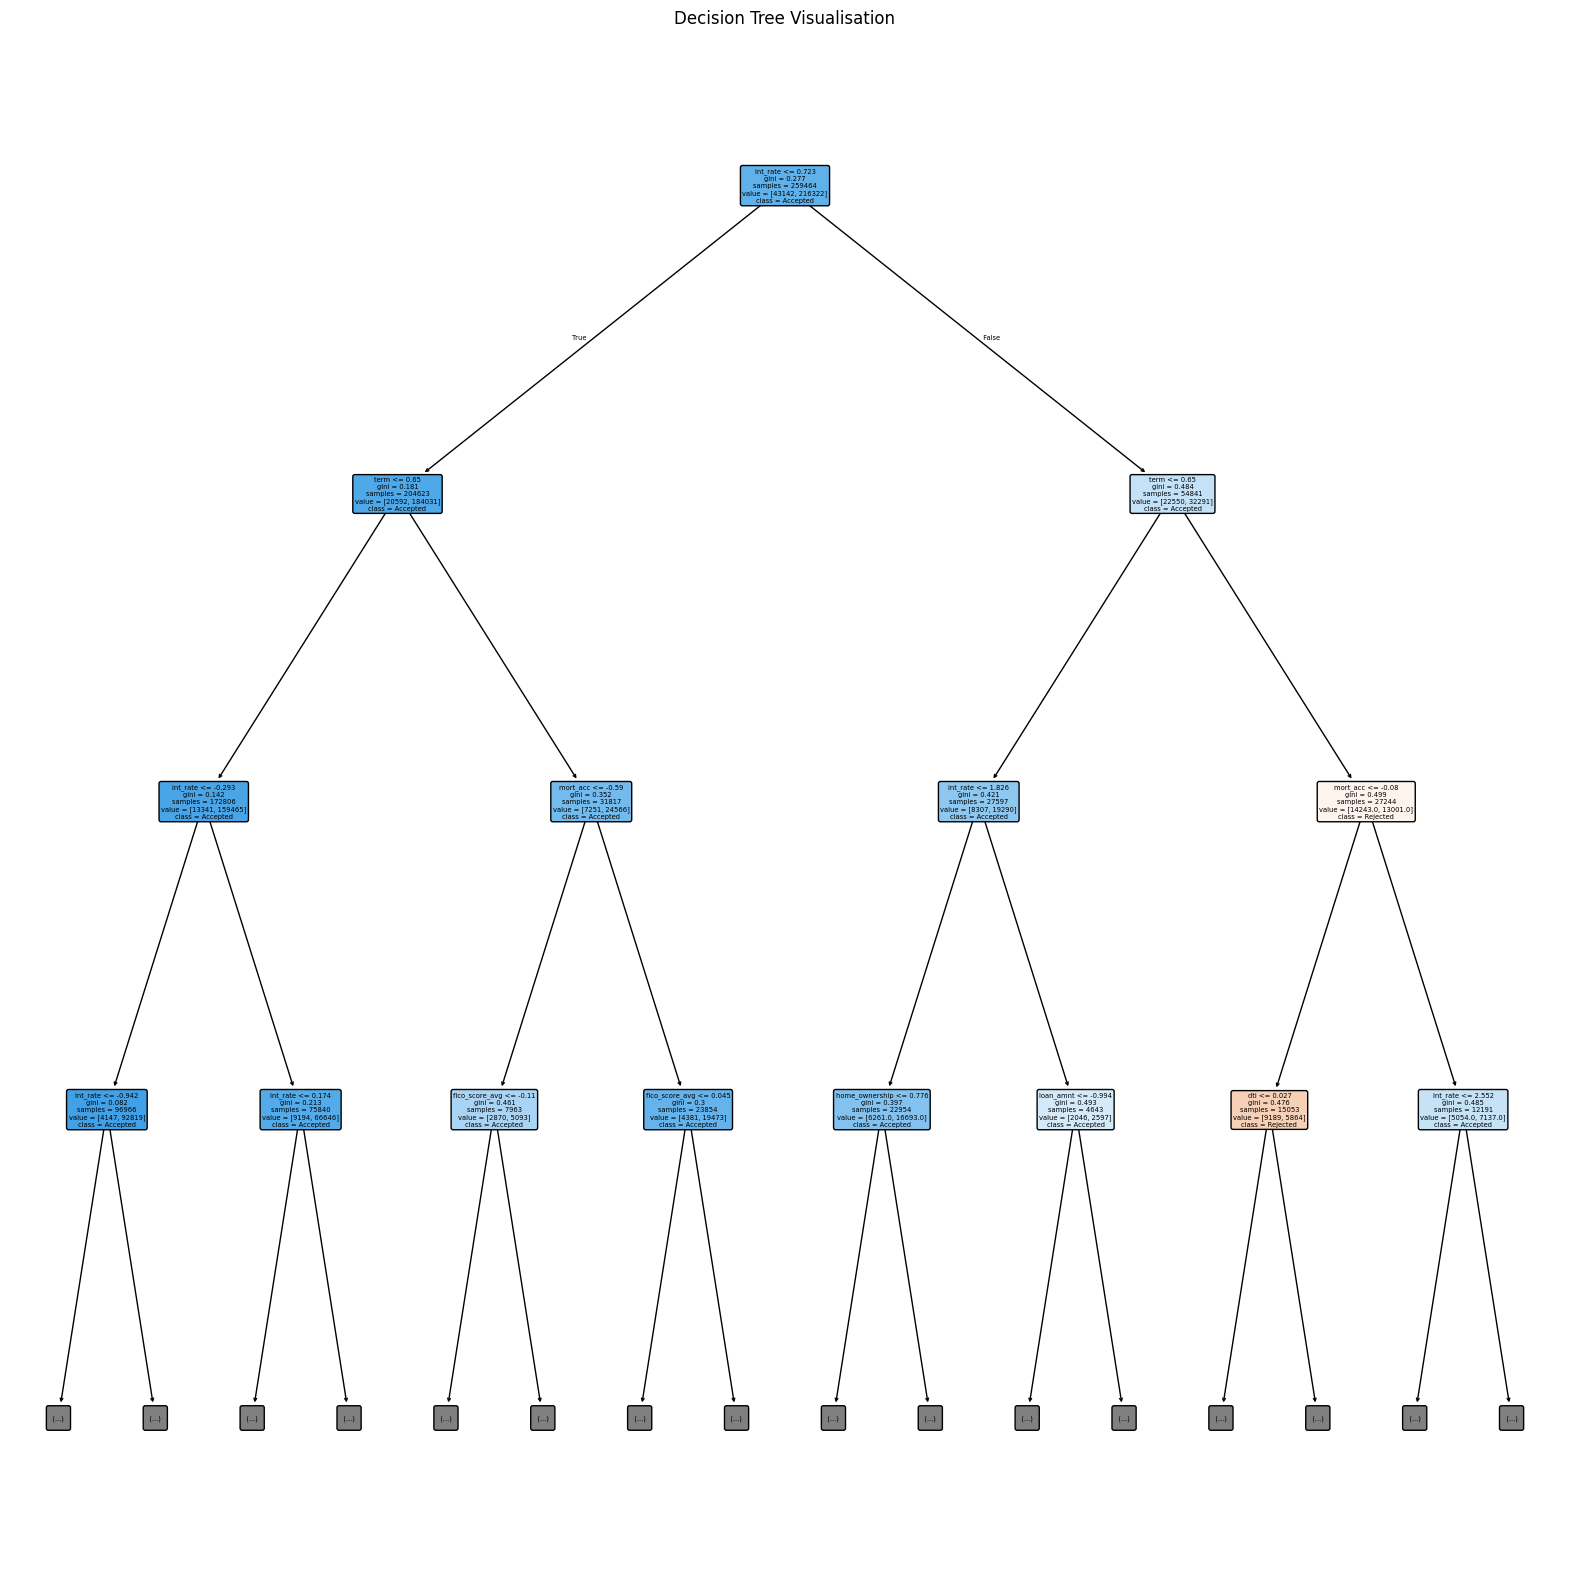

In [ ]:
# Plotting the best Decision Tree Model estimator
plt.figure(figsize=(20, 20))
plot_tree(best_dt, filled = True, feature_names = X_train.columns,  class_names = ['Rejected', 'Accepted'], rounded = True, max_depth = 3)
plt.title('Decision Tree Visualisation')
plt.show()

___
### 9.2 Gradient Boosting Model

In [ ]:
# Defining the second model - Gradient Boosting Model
gb_model = GradientBoostingClassifier(random_state = 42)

In [ ]:
# Defining the hyperparameters for tuning
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

**Insight:** These hyperparameters control the learning pace, tree complexity, and generalisation ability of the Gradient Boosting model:

*   *n_estimators:* Represents the number of boosting stages, as the number of estimators increases, the performance of the model improves but also risks overfitting.
*   *learning_rate:* Shrinks the contribution of each tree, lower values improve generalisation but require more trees.
*   *max_depth:* Limits the depth of individual trees, thereby controlling the model's complexity and overfitting.
*   *min_samples_split:* Minimum samples to split an internal node, where higher values restrict growth and smoothens the model.
*   *min_samples_leaf:* Minimum samples required at a leaf, which helps avoids leaves with too few samples and reduces the overall variance of the model.

Together, these parameters help balance bias and variance, enhance generalization, and stabilize learning for imbalanced datasets.

In [ ]:
# Use RandomSearchCV with cross-validation
random_gb = RandomizedSearchCV(estimator = gb_model, param_distributions = param_grid_gb, n_iter = 30, scoring = 'f1', n_jobs = -1, cv = 5, verbose = 2, random_state = 42)
random_gb.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'min_samples_leaf': [1, 3, 5],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='f1', verbose=2)

In [ ]:
# Display the best model parameters
print("Best parameters for Gradient Boosting Model:", random_gb.best_params_)

Best parameters for Gradient Boosting Model: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 7, 'learning_rate': 0.05}


**Insight:** After performing hyperparameter tuning using RandomSearchCV *(Given the size of the dataset and the complexity of the parameters, running GridSearchCV would be computationally expensive and time-consuming, making it impractical for obtaining optimal results within a reasonable timeframe)* with 5-fold cross-validation, the best parameters for the Gradient Boosting model were found to be:

{

  'n_estimators': 100, => The model builds 100 boosting stages (trees), providing a balance between the performance and complexity of the model, while not risking overfitting.

  'learning_rate': 0.05, => A small learning rate means each tree contributes only a little to the final prediction, helping the model learn slowly and generalise better.

  'max_depth': 7 => Each individual tree in the ensemble can grow up to 7 levels deep, allowing it to capture more complex patterns.

  'min_samples_leaf': 3, => A leaf must have at least 3 samples.

  'min_samples_split': 10 => A node must have at least 10 samples to be split.

}.

This configuration yielded the highest average cross-validated performance for this model.

In [ ]:
# Selecting the Gradient Boosting model with the best parameters
best_gb = random_gb.best_estimator_

In [ ]:
# Strtified K-Fold Cross Validation
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

**Insight:** To achieve a more reliable estimate of model performance and perform a meaningful comparison with the first model, *Stratified 5-fold Cross Validation* has been performed for this model as well.

In [ ]:
# Calculating the accuracy scores for the model using cross-validation
acc_scores_gb = cross_val_score(best_gb, X_train, y_train, cv = skf, scoring = 'accuracy')

In [ ]:
# Printing the accuracy scores for each fold and the mean accuracy
print("Stratified K-Fold accuracy scores for Gradient Boosting:", acc_scores_gb)
print("Mean accuracy score for Gradient Boosting:", acc_scores_gb.mean())

Stratified K-Fold accuracy scores for Gradient Boosting: [0.85502862 0.85545257 0.85329428 0.85472029 0.85622061]
Mean accuracy score for Gradient Boosting: 0.8549432725824756


In [ ]:
# Calculating the F1-scores for the model using cross-validation
f1_scores_gb = cross_val_score(best_gb, X_train, y_train, cv = skf, scoring = 'f1')

In [ ]:
# Printing the F1-scores for each fold and the mean F1-score
print("Stratified K-Fold F1 scores for Gradient Boosting:", f1_scores_gb)
print("Mean F1 score for Gradient Boosting:", f1_scores_gb.mean())

Stratified K-Fold F1 scores for Gradient Boosting: [0.91761305 0.9177134  0.91654151 0.91739259 0.91823472]
Mean F1 score for Gradient Boosting: 0.9174990523655664


**Insights:**


*   The accuracy scores show consistent performance across the 5 folds, with minimal variation, indicating that the Gradient Boosting model is stable and reliable.
*   The mean F1 score of 0.9171 demonstrates that the model does a strong job of balancing precision and recall, which is crucial for imbalanced datasets.
*   Given the emphasis on F1 scores due to the class imbalance, the Gradient Boosting model is performing well in correctly identifying both classes without favoring the majority class.



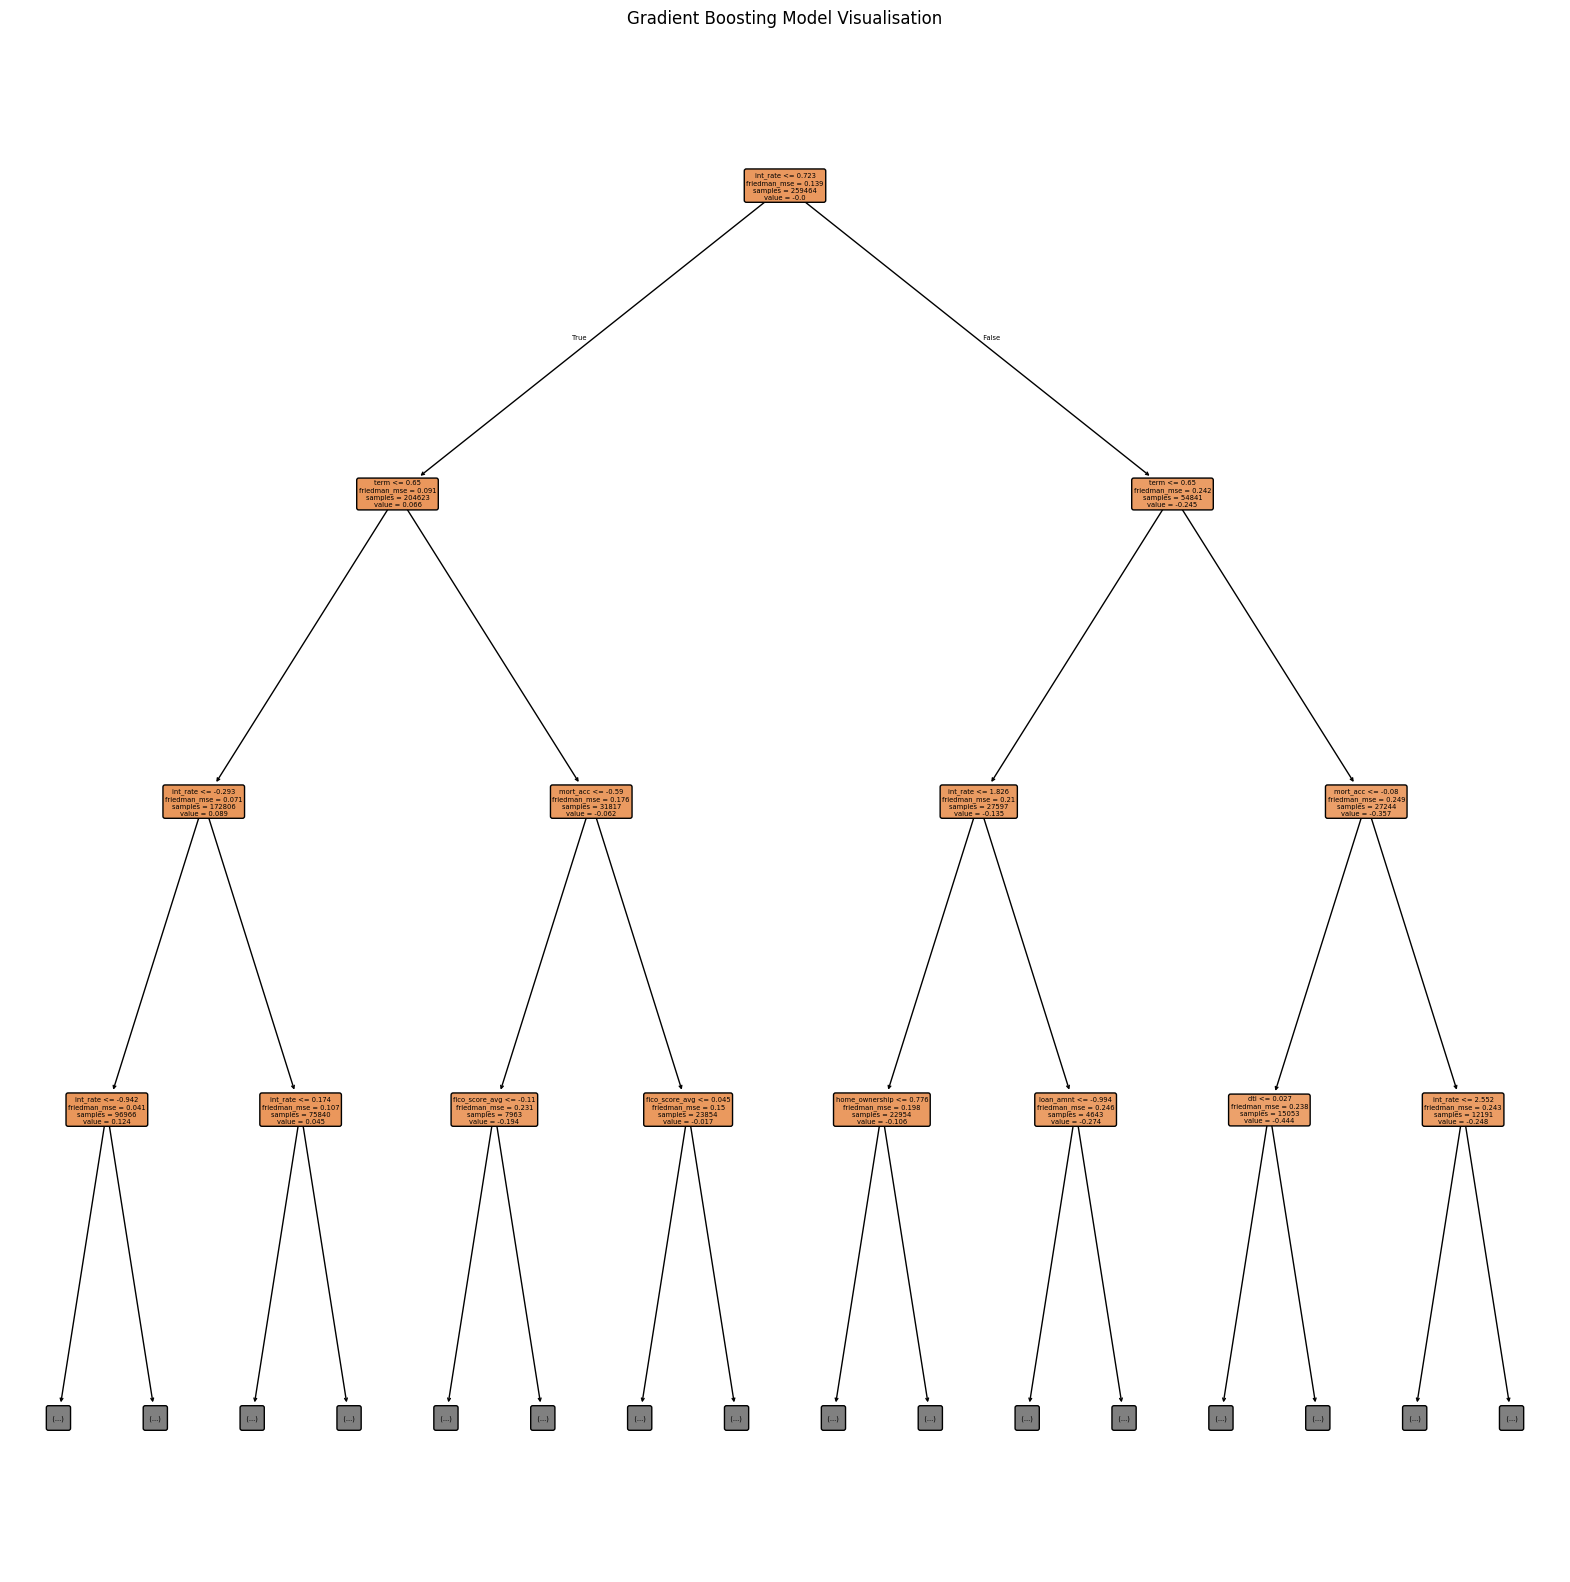

In [ ]:
# Plotting the best Gradient Boosting Model estimator
plt.figure(figsize = (20, 20))
plot_tree(best_gb.estimators_[0, 0], filled = True, feature_names = X_train.columns, class_names = ['Rejected', 'Accepted'], rounded = True, max_depth = 3)
plt.title('Gradient Boosting Model Visualisation')
plt.show()

___
# 10. Significance Testing - Paired T-Test

In [ ]:
# Calculating the difference in accuracy and F1 scores of the two models
acc_dif = acc_scores_gb - acc_scores_dt
f1_dif = f1_scores_gb - f1_scores_dt

In [ ]:
# 95% confidence level
alpha = 0.05

In [ ]:
# Conducting the Shapiro-Wilk's test to check for normality of the differences
shapiro_test_acc = stats.shapiro(acc_dif)
shapiro_test_f1 = stats.shapiro(f1_dif)

print(f"Shapiro-Wilk Test for accuracy p-value: {shapiro_test_acc.pvalue}")
print(f"Shapiro-Wilk Test for f1-score p-value: {shapiro_test_f1.pvalue}")

Shapiro-Wilk Test for accuracy p-value: 0.21941558808997008
Shapiro-Wilk Test for f1-score p-value: 0.39039193424221075


**Insight:** Since, the p-values for both performance metrics are greater than 0.05, we fail to reject the null hypothesis, indicating that the accuracy and F1-score distributions do not significantly deviate from normality. Hence, we can conduct the Paired T-Tests.

In [ ]:
# T-test for the differences in accuracy
t_test_acc = stats.ttest_rel(acc_scores_gb, acc_scores_dt)
print(f"T-test for accuracy p-value: {t_test_acc.pvalue}")

T-test for accuracy p-value: 1.98562945870814e-07


In [ ]:
# T-test for the differences in F1 scores
t_test_f1 = stats.ttest_rel(f1_scores_gb, f1_scores_dt)
print(f"T-test for f1-score p-value: {t_test_f1.pvalue}")

T-test for f1-score p-value: 4.96931403954223e-06


**Insight**: From the results, we can see that the p-values obtained from the T-tests conducted are both below the proposed confidence level. As such, the nuull hypothesis is rejected, indicating that the differences in accuracy and F1-score between the two models are statistically significant. This supports the conclusion that Gradient Boosting model significantly outperforms the Decision Tree model on this dataset.

___

# 11. Evaluating the effectiveness of the models

In [ ]:
# Predicting the target variable using the Decision Tree model
y_pred_dt = best_dt.predict(X_test)

In [ ]:
# Printing the accuracy and F1 score for the Decision Tree model on the test set
print("Accuracy for the Decision Tree:", accuracy_score(y_test, y_pred_dt))
print("F1 Score for the Decision Tree:", f1_score(y_test, y_pred_dt))

Accuracy for the Decision Tree: 0.8476705824314741
F1 Score for the Decision Tree: 0.9142728242857515


In [ ]:
# Predicting the target variable using the Gradient Boosting model
y_pred_gb = best_gb.predict(X_test)

In [ ]:
# Printing the accuracy and F1 score for the Gradient Boosting model on the test set
print("Accuracy for the Gradient Boosting Model:", accuracy_score(y_test, y_pred_gb))
print("F1 Score for the Gradient Boosting Model: ", f1_score(y_test, y_pred_gb))

Accuracy for the Gradient Boosting Model: 0.8554096136650942
F1 Score for the Gradient Boosting Model:  0.9177778362219359


**Insight:** From the results above, on the test dataset, we can conclude that the Gradient Boosting model outperformed the Decision Tree in both accuracy and F1 score. Combined with the statistically significant p-values from the t-tests, this confirms that Gradient Boosting is the better-performing model for this classification task.



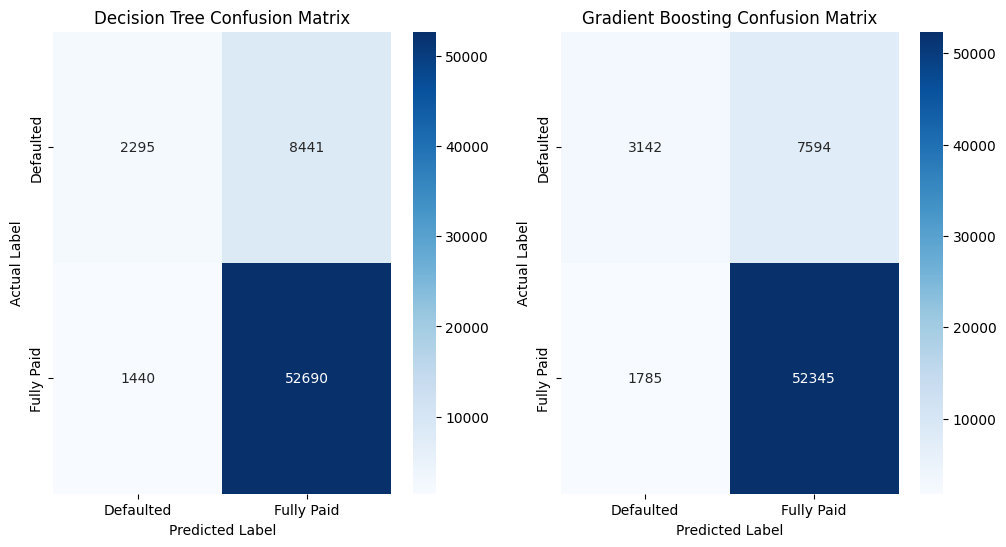

In [ ]:
# Plotting the confusion matrixes for both the models

# Calculating the confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_gb = confusion_matrix(y_test, y_pred_gb)

# Define the labels
labels = ['Defaulted', 'Fully Paid']

fig, axes = plt.subplots(1, 2, figsize = (12, 6))
# Decision Tree Confusion Matrix
sns.heatmap(cm_dt, annot = True, fmt = 'd', cmap = 'Blues', ax = axes[0], xticklabels = labels, yticklabels = labels)
axes[0].set_title('Decision Tree Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('Actual Label')

# Gradient Boost Confusion Matrix
sns.heatmap(cm_gb, annot = True, fmt = 'd', cmap = 'Blues', ax = axes[1], xticklabels = labels, yticklabels = labels)
axes[1].set_title('Gradient Boosting Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('Actual Label')
plt.show()

**Insights:** From the confusion matrix above, we can see that:
* Decision Tree misclassified a large number of defaulters (FN = 8,441), indicating a bias toward predicting "Fully Paid" — likely due to class imbalance.
* Gradient Boosting significantly improved default detection (TP = 3,142, FN reduced to 7,594), at the cost of a slight increase in false positives. This trade-off is acceptable when the priority is to loan defaulters more effectively.

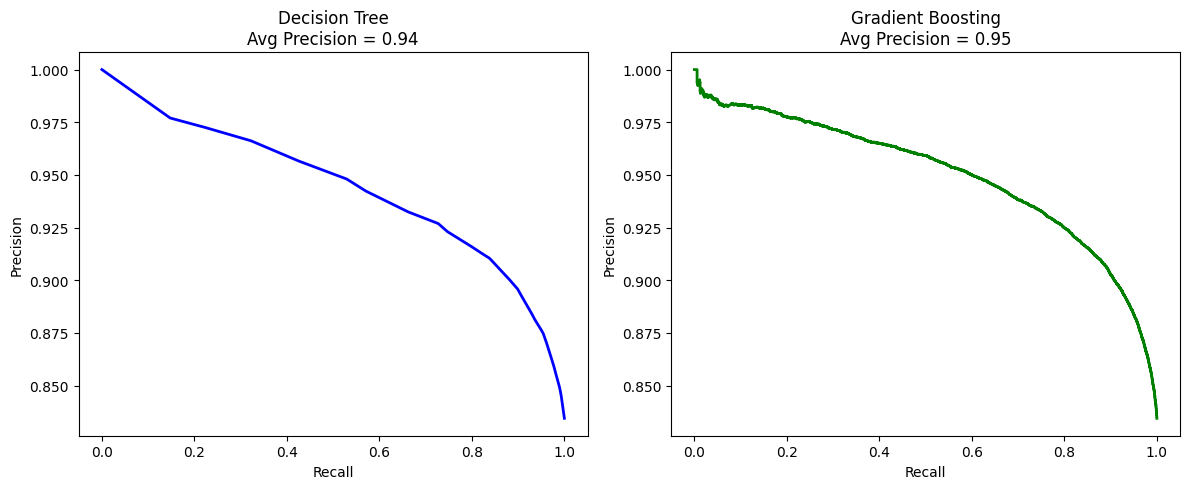

In [ ]:
# Plotting the Precision-Recall curve for the Decision Tree and Gradient Boosting Models

# Get predicted probabilities for class 1
dt_probs = best_dt.predict_proba(X_test)[:, 1]
gb_probs = best_gb.predict_proba(X_test)[:, 1]

# Calculate PR curve and average precision
dt_precision, dt_recall, _ = precision_recall_curve(y_test, dt_probs)
gb_precision, gb_recall, _ = precision_recall_curve(y_test, gb_probs)

dt_ap = average_precision_score(y_test, dt_probs)
gb_ap = average_precision_score(y_test, gb_probs)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Decision Tree PR Curve
axes[0].plot(dt_recall, dt_precision, color = 'blue', linewidth = 2)
axes[0].set_title(f'Decision Tree\nAvg Precision = {dt_ap:.2f}')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')

# Gradient Boosting PR Curve
axes[1].plot(gb_recall, gb_precision, color = 'green', linewidth = 2)
axes[1].set_title(f'Gradient Boosting\nAvg Precision = {gb_ap:.2f}')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')

plt.tight_layout()
plt.show()


**Insights:** From the Precision-Recall Curves:
* Decision Tree shows high precision but low recall, meaning it correctly identifies few defaulters — aligning with its high false negative rate.
* Gradient Boosting achieves a higher average precision (0.95) and a smoother PR curve, indicating a better balance between precision and recall.

Overall, Gradient Boosting provides improved default detection with minimal loss in precision.


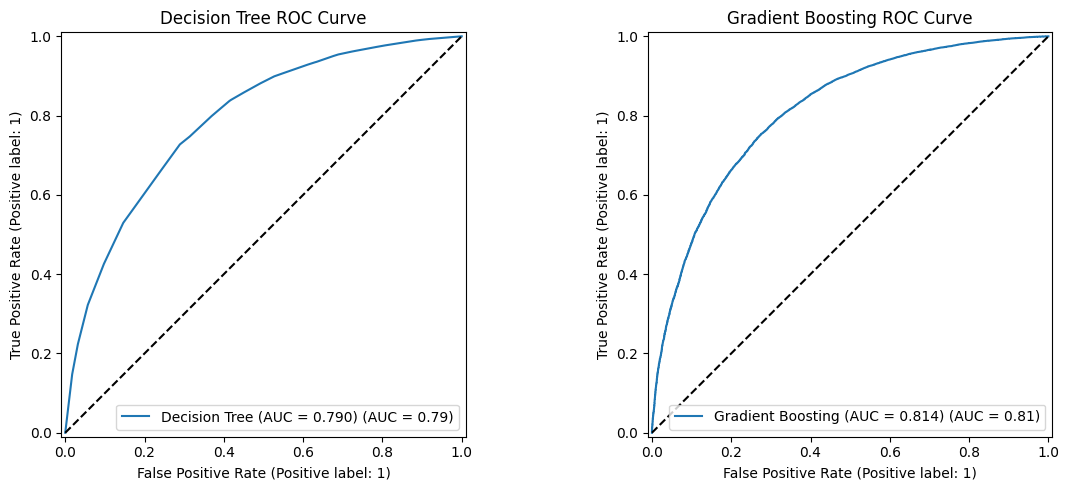

In [ ]:
# Calculate AUC scores
dt_auc = roc_auc_score(y_test, dt_probs)
gb_auc = roc_auc_score(y_test, gb_probs)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Decision Tree ROC
RocCurveDisplay.from_predictions(y_test, dt_probs, ax=axs[0], name=f"Decision Tree (AUC = {dt_auc:.3f})")
axs[0].plot([0, 1], [0, 1], 'k--')
axs[0].set_title("Decision Tree ROC Curve")

# Gradient Boosting ROC
RocCurveDisplay.from_predictions(y_test, gb_probs, ax=axs[1], name=f"Gradient Boosting (AUC = {gb_auc:.3f})")
axs[1].plot([0, 1], [0, 1], 'k--')
axs[1].set_title("Gradient Boosting ROC Curve")

plt.tight_layout()
plt.show()

**Insights:** From the ROC Curves, we can observe that:
* Decision Tree has an AUC of 0.79, indicating moderate ability to distinguish defaulters from non-defaulters — better than random but not strong.
* Gradient Boosting improves with an AUC of 0.81, showing better class separation across thresholds and stronger overall discrimination.

Though neither model is perfect, Gradient Boosting clearly performs better in terms of distinguishing between the two loan outcomes

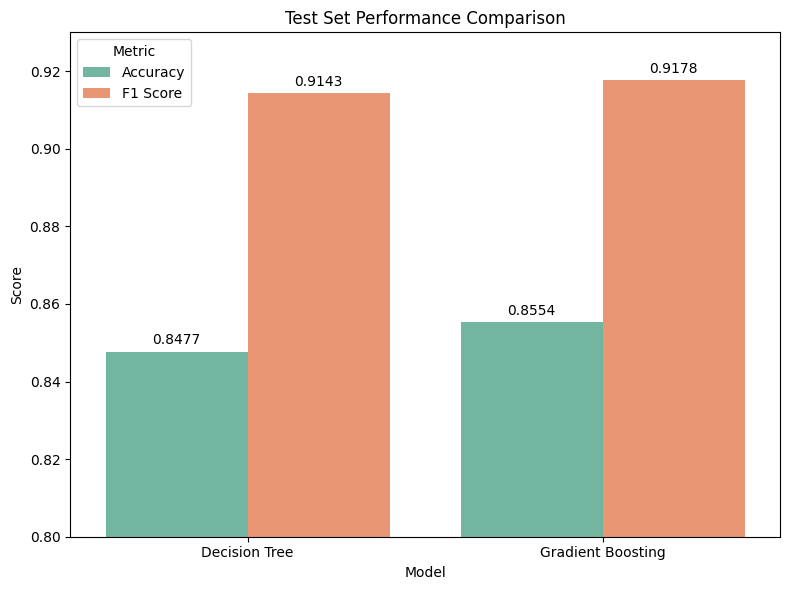

In [82]:
# Plotting the test set performance comparison between Decision Tree and Gradient Boosting Models
# Data
data = {
    'Model': ['Decision Tree', 'Decision Tree', 'Gradient Boosting', 'Gradient Boosting'],
    'Metric': ['Accuracy', 'F1 Score', 'Accuracy', 'F1 Score'],
    'Score': [0.8477, 0.9143, 0.8554, 0.9178]
}

df_plot = pd.DataFrame(data)

# Plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_plot, x='Model', y='Score', hue='Metric', palette='Set2')
plt.title('Test Set Performance Comparison')
plt.ylim(0.80, 0.93)
plt.ylabel('Score')
plt.legend(title='Metric')

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', padding=3)

plt.tight_layout()
plt.show()


___

To conclude, Gradient Boosting is superior across all three metrics:
* Improved default detection (higher TP, lower FN)
* Stronger precision-recall trade-off
* Higher AUC, indicating better class separation

These results confirm Gradient Boosting as the more effective and reliable model for this classification task.

___

# The End